In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split
from network import neural_network
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    with open('files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (128, 128, 3)
files_list = read_pictures('preprocessed_images/')
# files_list = read_pictures()

In [4]:
def preprocess_img(img):
    return skimage.transform.resize(img, input_shape)

In [6]:
def get_dataset(preprocess = True, files_num=1000):
    X = np.empty((files_num, *input_shape), dtype=np.float32)
    y = np.empty((files_num, 2), dtype=np.uint8)
    
    files_to_read = np.random.choice(files_list, files_num)
    for num, i in enumerate(tqdm.tqdm(files_to_read)):
        if preprocess:
            X[num] = preprocess_img(cv2.imread(i))[:,:,::-1]
        else:
            X[num] = cv2.imread(i)[:,:,::-1]
            
        if 'cat' in i:
            y[num] = [1, 0]
        else:
            y[num] = [0, 1]
    return X, y

In [7]:
def save_preprocessed_images(images):
    for i, name in tqdm.tqdm(zip(images, files_list)):
        plt.imsave(f'preprocessed_images/{name.split("/")[-1]}', i)

In [8]:
X, y = get_dataset(preprocess=True, files_num=25000)

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  4%|███▍                                                                         | 1104/25000 [00:11<04:11, 95.10it/s]

KeyboardInterrupt: 

In [8]:
save_preprocessed_images(X)

25000it [01:51, 223.98it/s]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

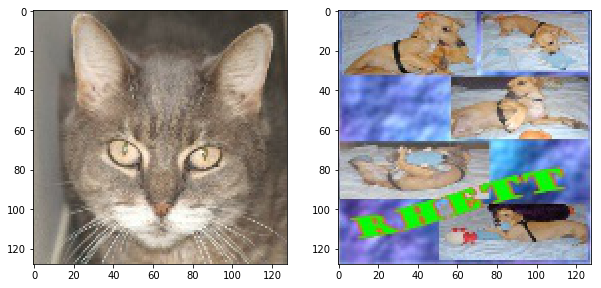

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[1]);
plt.subplot(122)
plt.imshow(X[0])
plt.show()

In [11]:
class cnn_network(neural_network):       
    def _inference(self):
        inp = self.input
        with tf.name_scope('classificator'):
            with tf.name_scope('convolution'):
#                 layer = tf.layers.conv2d(inp, 3, 1, activation=tf.nn.relu, name='deep_dreaming_input', padding='same')
                layer = tf.layers.conv2d(inp, 8, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 32, 5, activation=tf.nn.relu, padding='same')
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
    #             layer = tf.layers.conv2d(layer, 16, 5, activation=tf.nn.relu)
    #             layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.flatten(layer)

            with tf.name_scope('dense'):
                layer = tf.layers.dense(layer, 1024, activation=tf.nn.relu)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.dense(layer, 512, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 2, activation=tf.nn.softmax)

        return layer

In [12]:
# if network is None:
network = cnn_network(input_shape, X_train, y_train, X_test, y_test)
network.training(batch_size=128, epochs=15, iter_before_validation=1)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Test accuracy: 61% 	Training loss: 0.6545982010224287 	 Training accuracy: 67%


  7%|█████▌                                                                             | 1/15 [00:11<02:37, 11.25s/it]

Test accuracy: 73% 	Training loss: 0.5747411535943255 	 Training accuracy: 78%


 13%|███████████                                                                        | 2/15 [00:19<02:04,  9.56s/it]

Test accuracy: 80% 	Training loss: 0.5268651862793109 	 Training accuracy: 76%


 20%|████████████████▌                                                                  | 3/15 [00:27<01:48,  9.02s/it]

Test accuracy: 83% 	Training loss: 0.49384920518187914 	 Training accuracy: 83%


 27%|██████████████████████▏                                                            | 4/15 [00:34<01:36,  8.74s/it]

Test accuracy: 84% 	Training loss: 0.4770690463483336 	 Training accuracy: 85%


 33%|███████████████████████████▋                                                       | 5/15 [00:42<01:25,  8.57s/it]

Test accuracy: 81% 	Training loss: 0.4751948223394505 	 Training accuracy: 89%


 40%|█████████████████████████████████▏                                                 | 6/15 [00:50<01:16,  8.47s/it]

Test accuracy: 86% 	Training loss: 0.4510165954775669 	 Training accuracy: 84%


 47%|██████████████████████████████████████▋                                            | 7/15 [00:58<01:07,  8.39s/it]

Test accuracy: 86% 	Training loss: 0.44457297815996055 	 Training accuracy: 87%


 53%|████████████████████████████████████████████▎                                      | 8/15 [01:06<00:58,  8.33s/it]

Test accuracy: 84% 	Training loss: 0.4435931310495908 	 Training accuracy: 88%


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [01:14<00:49,  8.29s/it]

Test accuracy: 86% 	Training loss: 0.43494745606885243 	 Training accuracy: 89%


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [01:22<00:41,  8.24s/it]

Test accuracy: 88% 	Training loss: 0.4264054999631994 	 Training accuracy: 89%


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [01:30<00:32,  8.20s/it]

Test accuracy: 88% 	Training loss: 0.4236158388940728 	 Training accuracy: 91%


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [01:38<00:24,  8.18s/it]

Test accuracy: 88% 	Training loss: 0.4180800634271956 	 Training accuracy: 92%


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [01:46<00:16,  8.16s/it]

Test accuracy: 87% 	Training loss: 0.41871982418438974 	 Training accuracy: 89%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [01:53<00:08,  8.13s/it]

Test accuracy: 86% 	Training loss: 0.4113782819579629 	 Training accuracy: 93%


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:01<00:00,  8.12s/it]


In [13]:
assert len([op.name for op in tf.get_default_graph().get_operations() if 'output' in op.name or 'features' in op.name]) == 2
assert len([op.name for op in tf.get_default_graph().get_operations() if 'cnn_' in op.name]) == 0

In [14]:
network.save_model('saved_model/classifier_color.ckpt')